In [ ]:
__author__ = "Kristian Olsen / NMBU"
__email__ = "kristian.olsen@nmbu.no"

# Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, make_scorer
from sklearn.metrics import accuracy_score, classification_report



# Load data

In [ ]:

# Load data from csv, the xlsx is beforehand converted into .csv for easier management
df = pd.read_csv('/content/Cube-data_Tberg_total_24032021.csv', sep = ';')

# show first rows and information to get initial understanding of the data
print(df.head(), df.info())
print("Shape:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162517 entries, 0 to 162516
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   fra-sone    162517 non-null  int64 
 1   til-sone    162517 non-null  int64 
 2   fra-Grk     162517 non-null  int64 
 3   Til-Grk     162517 non-null  int64 
 4   Reiser      162517 non-null  object
 5   Ndays       162517 non-null  object
 6   Distance    162517 non-null  object
 7   TotBef      162517 non-null  object
 8   Arb         162517 non-null  int64 
 9   Handel      162517 non-null  int64 
 10  FriHenPriv  162517 non-null  int64 
 11  Gange       162517 non-null  object
 12  Sykkel      162517 non-null  object
 13  Bil         162517 non-null  object
 14  Bilpass     162517 non-null  object
 15  PT          162517 non-null  object
dtypes: int64(7), object(9)
memory usage: 19.8+ MB
   fra-sone  til-sone  fra-Grk  Til-Grk      Reiser        Ndays Distance  \
0        63        63  

<ipython-input-21-666d78a693d4>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Cube-data_Tberg_total_24032021.csv', sep = ';')


# Data processing and feature engineering

In [ ]:
# rename features from Norwegian to English
rename_dict= {'fra-sone':'origin-zone',
              'til-sone':'destination-zone',
              'fra-Grk':'origin-area',
              'Til-Grk':'destination-area',
              'Reiser':'Trips',
              'TotBef':'TotPop',
              'Arb':'Work',
              'Handel':'Retail',
              'FriHenPriv':'RecDelPriv',
              'Gange':'Walk',
              'Sykkel':'Bicycle',
              'Bil':'Car',
              'Bilpass':'Carpass'
              }

df = df.rename(columns = rename_dict)

# drop columns that origin from travel survey and being duplicate features
df = df.drop(['origin-area', # duplicate information
              'destination-area', # duplicate information
              'Ndays', # irrelevant
              'Walk', # origins from travel survey
              'Bicycle', # origins from travel survey
              'Car', # origins from travel survey
              'Carpass', # origins from travel survey
              'PT'], # origins from travel survey
              axis = 1
             )

# convert features from data object to numerical
object_columns = ['Trips', 'Distance', 'TotPop']

for column in object_columns:
  df[column] = df[column].str.replace(',', '.').astype(float)
  df[column] = pd.to_numeric(df[column])

print(df.head()) # control the renaming

# Check for missing values and duplicates
print(df.isnull().sum())
print(np.isnan(df).sum())
print("Has duplicates:", df.duplicated().any())

   origin-zone  destination-zone       Trips  Distance  TotPop  Work  Retail  \
0           63                63  32656.5394     48.13  937.66  2350     976   
1           63               112   1004.2796     70.48  937.66    64       1   
2           63               113    700.8293     67.50  937.66    23       5   
3           63               114   1155.1804     65.09  937.66    48       0   
4           63               115   2852.9078     64.43  937.66   134      34   

   RecDelPriv  
0        1063  
1          40  
2          14  
3          43  
4          87  
origin-zone         0
destination-zone    0
Trips               0
Distance            0
TotPop              0
Work                0
Retail              0
RecDelPriv          0
dtype: int64
origin-zone         0
destination-zone    0
Trips               0
Distance            0
TotPop              0
Work                0
Retail              0
RecDelPriv          0
dtype: int64
Has duplicates: False


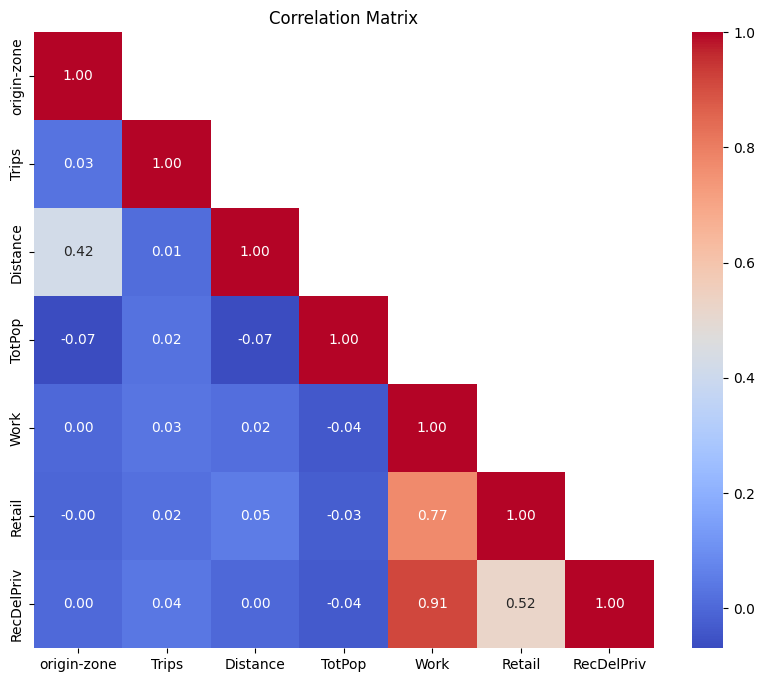

In [ ]:
# Correlation matrix for feature engineering
df_corr = df.drop('destination-zone', axis=1)
corr_matrix = df_corr.corr()

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Create a Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

## Statistical analysis

In [ ]:
# simple statistical overview of all features
df.describe()

# Further statistical analysis was conducted directly in the excel file

,origin-zone,destination-zone,Trips,Distance,TotPop,Work,Retail,RecDelPriv
count,162517.000000,162517.000000,162517.000000,162517.000000,162517.000000,162517.000000,162517.000000,162517.000000
mean,405.438010,400.656787,487.679474,42.619092,511.894167,276.925866,55.124565,161.651833
std,244.956937,237.987728,5019.423279,43.684884,382.789851,470.336909,129.343188,331.830589
min,63.000000,63.000000,5.000000,0.010000,0.000000,0.000000,0.000000,0.000000
25%,217.000000,217.000000,13.835800,20.480000,210.400000,28.000000,1.000000,6.000000
50%,342.000000,337.000000,50.516400,31.520000,414.570000,103.000000,8.000000,41.000000
75%,573.000000,571.000000,217.647300,45.840000,729.590000,288.000000,42.000000,163.000000
max,1343.000000,1343.000000,901785.580600,350.000000,2014.950000,3603.000000,976.000000,3557.000000


## Principal Component Analysis

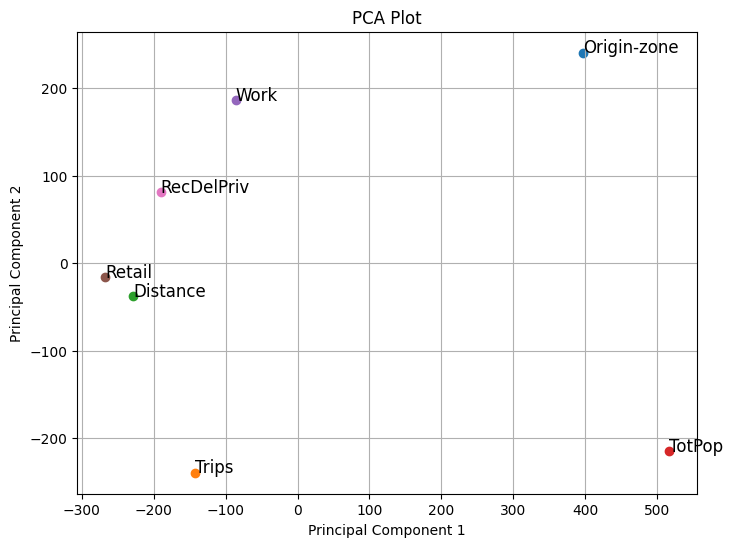

Explained variance by component: [0.53926733 0.17929342]


In [ ]:
# Initializing Loading-plot for whole dataset
df_pca = df.drop('destination-zone', axis=1)
scaler = StandardScaler()
data_standardized = scaler.fit_transform(df_pca.T)

pca = PCA(n_components=2)  # Reduce to 2 dimensions
principal_components = pca.fit_transform(data_standardized)

feature_names = ['Origin-zone', 'Trips', 'Distance','TotPop','Work','Retail','RecDelPriv']

# Plotting the PCA
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(principal_components):
    plt.scatter(x, y, marker='o', label=f'{feature_names[i]}')  # Plot points
    plt.text(x, y, feature_names[i], fontsize=12)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')
plt.grid(True)
plt.show()
print(f"Explained variance by component: {pca.explained_variance_ratio_}")


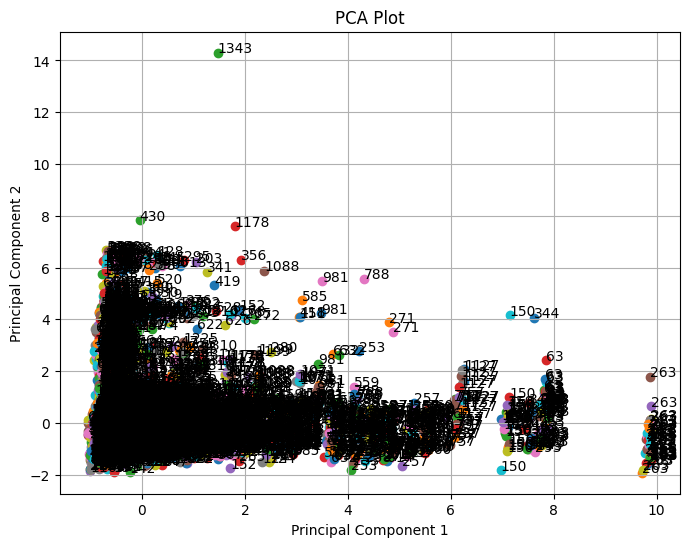

Explained variance by component: [0.35241162 0.20573759]


In [ ]:
# Initialize score plot of n = 10 000 samples from the dataset
df_pca_2 = df
df_pca_sample = df_pca_2.sample(n=10000, random_state=42)
unique_labels_3 = df_pca_sample['destination-zone'].tolist()
df_pca_sample = df_pca_sample.drop('destination-zone', axis=1)

scaler = StandardScaler()
data_standardized = scaler.fit_transform(df_pca_sample)

pca = PCA(n_components=2)  # Reduce to 2 dimensions
principal_components = pca.fit_transform(data_standardized)

# Plotting the PCA
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(principal_components):
    plt.scatter(x, y, marker=None,label=f'{unique_labels_3[i]}')
    plt.text(x, y, unique_labels_3[i], fontsize=10)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')
plt.grid(True)
plt.show()
print(f"Explained variance by component: {pca.explained_variance_ratio_}")

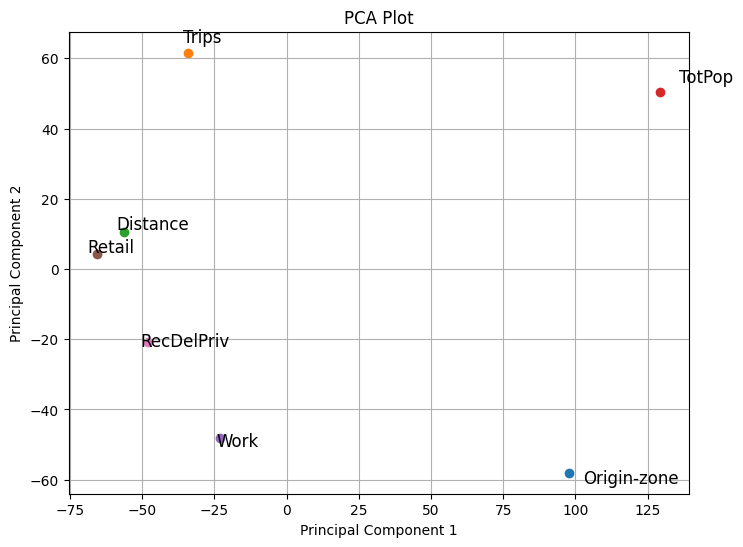

Explained variance by component: [0.53936215 0.18000579]


In [ ]:
# Initialize loading plot of n = 10 000 samples from the dataset
df_pca_3 = df
df_pca_sample_2 = df_pca_3.sample(n=10000, random_state=42)
data_standardized = scaler.fit_transform(df_pca_sample.T)

pca = PCA(n_components=2)  # Reduce to 2 dimensions
principal_components = pca.fit_transform(data_standardized)

feature_names = ['Origin-zone', 'Trips', 'Distance','TotPop','Work','Retail','RecDelPriv']

# Plotting the PCA
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(principal_components):
    plt.scatter(x, y, marker='o', label=f'{feature_names[i]}')  # Plot points
    plt.text(x * 1.05, y * 1.05, feature_names[i], fontsize=12)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')
plt.grid(True)
plt.show()
print(f"Explained variance by component: {pca.explained_variance_ratio_}")

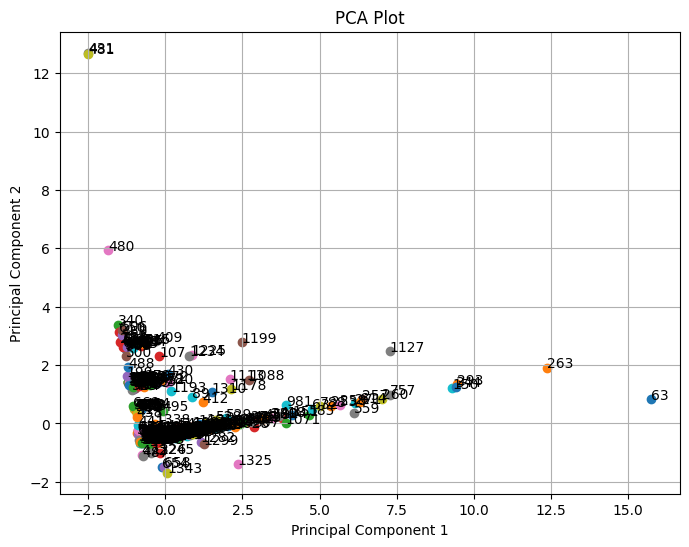

Explained variance by component: [0.39873333 0.2060545 ]


In [ ]:
# Intialize score plot for unique destination zones
unique_df = df.drop_duplicates(subset='destination-zone', keep='first')
df_pca_unique = unique_df.drop('destination-zone', axis=1)
scaler = StandardScaler()
data_standardized = scaler.fit_transform(df_pca_unique)

pca = PCA(n_components=2)  # Reduce to 2 dimensions
principal_components = pca.fit_transform(data_standardized)

unique_labels = df['destination-zone'].unique().tolist()

# Plotting the PCA
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(principal_components):
    plt.scatter(x, y, marker=None,label=f'{unique_labels[i]}')  # Plot points
    plt.text(x, y, unique_labels[i], fontsize=10)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')
plt.grid(True)
plt.show()
print(f"Explained variance by component: {pca.explained_variance_ratio_}")

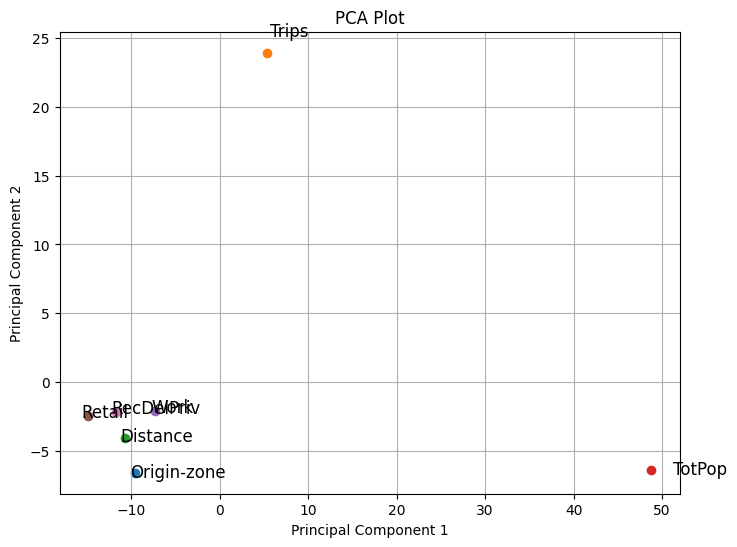

Explained variance by component: [0.73470751 0.16765431]


In [ ]:
# Intialize loading plot for unique destination zones
unique_df = df.drop_duplicates(subset='destination-zone', keep='first')
df_pca_unique = unique_df.drop('destination-zone', axis=1)
scaler = StandardScaler()
data_standardized = scaler.fit_transform(df_pca_unique.T)

pca = PCA(n_components=2)  # Reduce to 2 dimensions
principal_components = pca.fit_transform(data_standardized)

feature_names = ['Origin-zone', 'Trips', 'Distance','TotPop','Work','Retail','RecDelPriv']

# Plotting the PCA
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(principal_components):
    plt.scatter(x, y, marker='o', label=f'{feature_names[i]}')  # Plot points
    plt.text(x * 1.05, y * 1.05, feature_names[i], fontsize=12)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')
plt.grid(True)
plt.show()
print(f"Explained variance by component: {pca.explained_variance_ratio_}")

# Remove outliers and violin plots

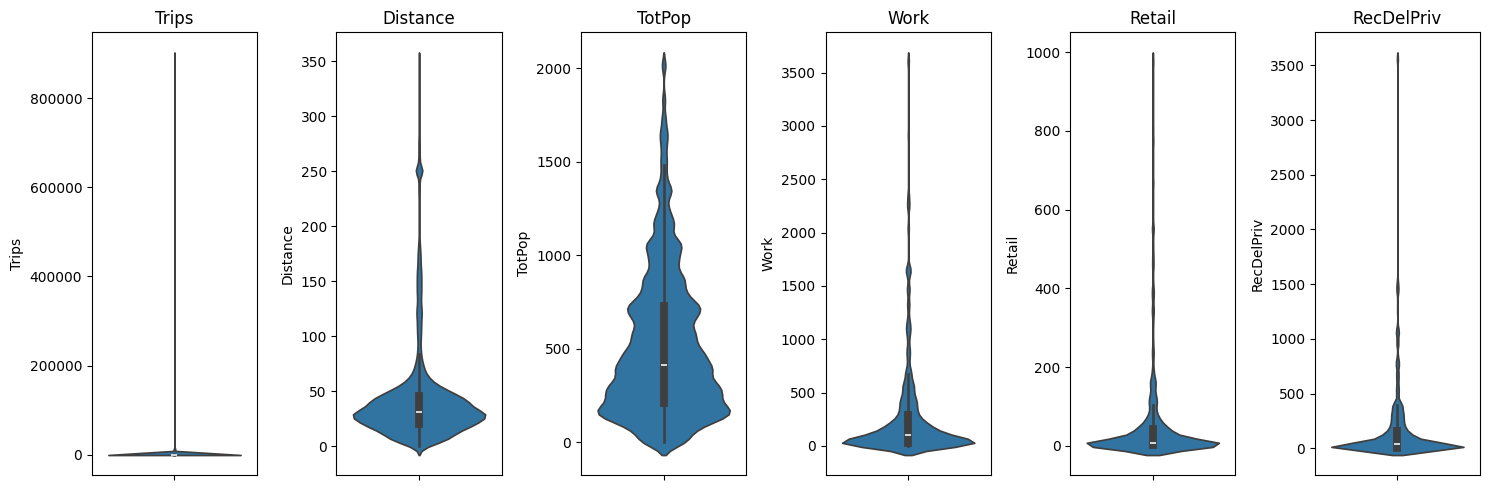

In [ ]:
# Violin plots of data
data_to_plot = df.iloc[:, 2:8]

# Set up a matplotlib figure and array of axes, with 1 row and enough columns
fig, axes = plt.subplots(nrows=1, ncols=len(data_to_plot.columns), figsize=(15, 5))  # Adjust figsize as needed

# Loop through each subplot axis and column data
for ax, (colname, coldata) in zip(axes, data_to_plot.items()):
    sns.violinplot(y=coldata, ax=ax)  # Use 'y' to specify the data
    ax.set_title(colname)  # Set title to column name

# Show the plot
plt.tight_layout()
plt.show()

       Trips  Distance  TotPop  Work  Retail  RecDelPriv
9   359.4839     74.06  937.66    14       0           4
11  361.1610     72.83  937.66    55       6          37
12  307.6142     76.19  937.66     7       0           7
14  243.0892     70.04  937.66    73      42           1
15  130.6306     68.54  937.66     1       0           0


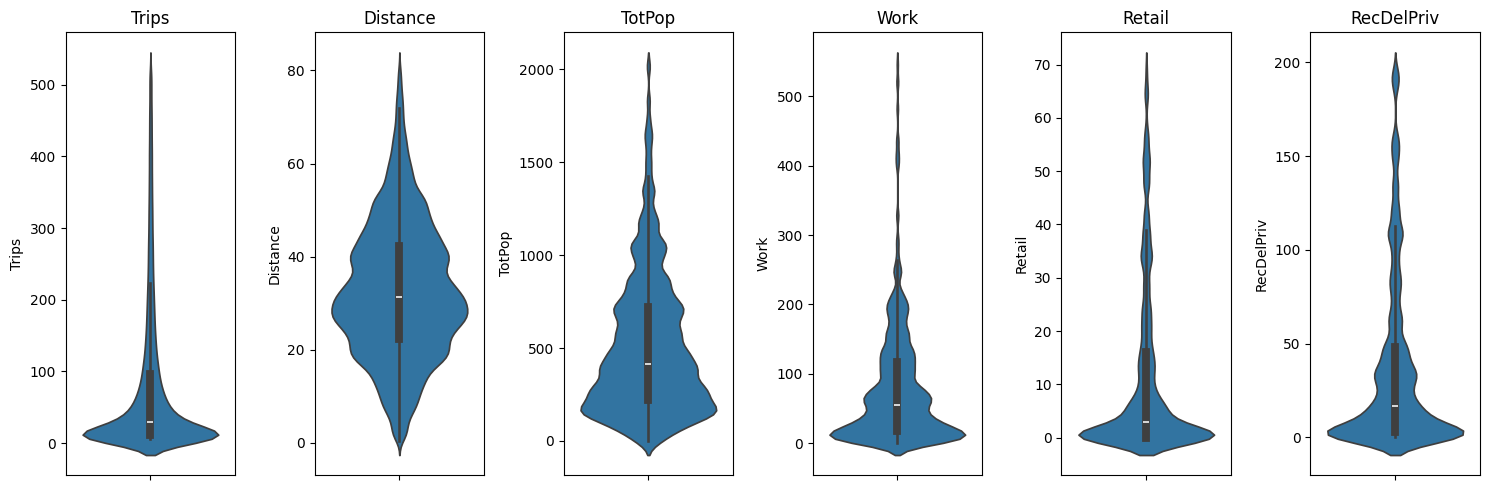

In [ ]:
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    df_filtered = df[(df[feature] <= upper_bound)]
    return df_filtered

feature_list = ['Trips','Distance','Work','Retail','RecDelPriv']

# Applying the function to each of the features
features = feature_list
for feature in features:
    df = remove_outliers(df, feature)

# Second visualization of violin plots to further investigate skewedness
data_to_plot = df.iloc[:, 2:8]

# Set up a figure
fig, axes = plt.subplots(nrows=1, ncols=len(data_to_plot.columns), figsize=(15, 5))

# Go through each subplot and column data
for ax, (colname, coldata) in zip(axes, data_to_plot.items()):
    sns.violinplot(y=coldata, ax=ax)  # Use 'y' to specify the data
    ax.set_title(colname)

# Show the plot
plt.tight_layout()
plt.show()

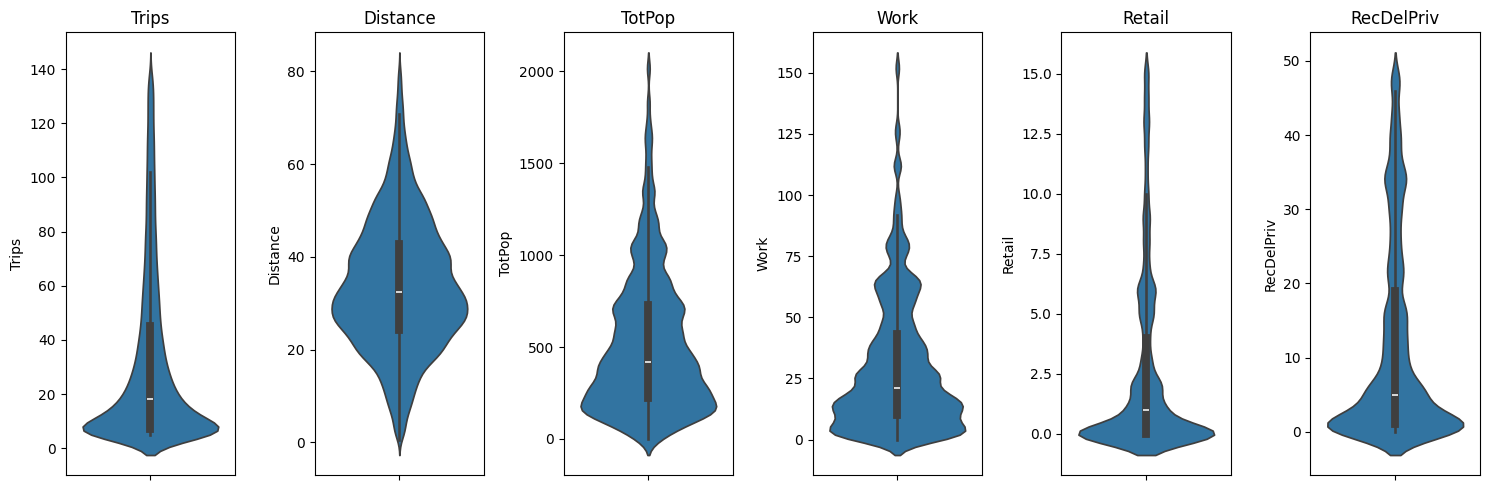

In [ ]:
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 0.5 * IQR

    # Filter out outliers
    df_filtered = df[(df[feature] <= upper_bound)]
    return df_filtered

feature_list = ['Trips','Work','Retail','RecDelPriv']

# Applying the function
features = feature_list
for feature in features:
    df = remove_outliers(df, feature)

# A third visualization with violin plots
data_to_plot = df.iloc[:, 2:8]

# Set up a figure
fig, axes = plt.subplots(nrows=1, ncols=len(data_to_plot.columns), figsize=(15, 5))  # Adjust figsize as needed

# Go through each subplot axis and column data
for ax, (colname, coldata) in zip(axes, data_to_plot.items()):
    sns.violinplot(y=coldata, ax=ax)
    ax.set_title(colname)

# Show the plot
plt.tight_layout()
plt.show()

# Data modelling and hyperparameter tuning

In [ ]:
# Pipeline for Logistic Regression
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs']
}

# Pipeline for SVC
pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])
param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

# Pipeline for Random Forest
pipe_rf = Pipeline([
    ('classifier', RandomForestClassifier())
])
param_grid_rf = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30]
}

# Pipeline for Gaussian Naive Bayes
pipe_nb = Pipeline([
    ('classifier', GaussianNB())
])

param_grid_nb = {}

# seperate training data from response variable
X = df.drop('destination-zone', axis=1)
y = df['destination-zone']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def perform_grid_search(pipe, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(pipe, param_grid, cv=2, verbose=1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_)) #shows accuracy performance

    # Evaluate on the test set
    y_pred = grid_search.predict(X_test)

    # Calculate Metrics
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"MCC: {mcc}")
    print(classification_report(y_test, y_pred))

# Apply the function to each classifier
print("Logistic Regression Results:")
perform_grid_search(pipe_lr, param_grid_lr, X_train, y_train, X_test, y_test)

print("SVC Results:")
perform_grid_search(pipe_svc, param_grid_svc, X_train, y_train, X_test, y_test)

print("Random Forest Results:")
perform_grid_search(pipe_rf, param_grid_rf, X_train, y_train, X_test, y_test)

print('Gaussian Naive Bayes Results:')
perform_grid_search(pipe_nb, param_grid_nb, X_train, y_train, X_test, y_test)


Logistic Regression Results:
Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modu

Best parameters: {'classifier__C': 100, 'classifier__solver': 'lbfgs'}
Best cross-validation score: 0.833
Precision: 0.78
Recall: 0.76
F1-Score: 0.76
MCC: 0.8609548851743628
              precision    recall  f1-score   support

         112       1.00      1.00      1.00        50
         113       1.00      1.00      1.00        45
         114       1.00      1.00      1.00        64
         116       0.65      0.77      0.71        61
         119       1.00      1.00      1.00        46
         120       0.50      0.71      0.59        41
         122       1.00      1.00      1.00        51
         123       0.73      1.00      0.84        54
         126       0.73      0.37      0.49        43
         127       1.00      1.00      1.00        56
         129       0.94      0.94      0.94        48
         130       1.00      1.00      1.00        21
         131       1.00      1.00      1.00        39
         132       1.00      1.00      1.00        61
         133   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

Precision: 0.82
Recall: 0.83
F1-Score: 0.82
MCC: 0.9177748713492305
              precision    recall  f1-score   support

         112       1.00      1.00      1.00        50
         113       1.00      1.00      1.00        45
         114       1.00      1.00      1.00        64
         116       0.95      1.00      0.98        61
         119       1.00      1.00      1.00        46
         120       0.98      1.00      0.99        41
         122       1.00      1.00      1.00        51
         123       0.98      1.00      0.99        54
         126       0.88      0.84      0.86        43
         127       1.00      1.00      1.00        56
         129       0.98      0.98      0.98        48
         130       1.00      1.00      1.00        21
         131       1.00      1.00      1.00        39
         132       1.00      1.00      1.00        61
         133       1.00      1.00      1.00        47
         136       1.00      1.00      1.00        39
         146 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

Precision: 0.89
Recall: 0.88
F1-Score: 0.89
MCC: 0.9486921713578612
              precision    recall  f1-score   support

         112       1.00      1.00      1.00        50
         113       1.00      1.00      1.00        45
         114       1.00      1.00      1.00        64
         116       0.94      1.00      0.97        61
         119       1.00      1.00      1.00        46
         120       0.98      0.98      0.98        41
         122       1.00      1.00      1.00        51
         123       1.00      1.00      1.00        54
         126       0.91      0.91      0.91        43
         127       1.00      1.00      1.00        56
         129       1.00      0.98      0.99        48
         130       1.00      1.00      1.00        21
         131       1.00      1.00      1.00        39
         132       1.00      1.00      1.00        61
         133       1.00      1.00      1.00        47
         136       1.00      1.00      1.00        39
         146 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Best parameters: {}
Best cross-validation score: 0.926
Precision: 0.87
Recall: 0.86
F1-Score: 0.86
MCC: 0.9248886147930643
              precision    recall  f1-score   support

         112       1.00      1.00      1.00        50
         113       1.00      1.00      1.00        45
         114       1.00      1.00      1.00        64
         116       1.00      1.00      1.00        61
         119       1.00      1.00      1.00        46
         120       1.00      1.00      1.00        41
         122       1.00      1.00      1.00        51
         123       1.00      1.00      1.00        54
         126       0.88      0.88      0.88        43
         127       1.00      1.00      1.00        56
         129       1.00      1.00      1.00        48
         130       1.00      1.00      1.00        21
         131       1.00      1.00      1.00        39
         132       1.00      1.00      1.00        61
         133       1.00      1.00      1.00        47
         136

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWa

# Evaluation: Five-fold cross-validation

In [33]:
# Dictionaries with best hyperparameters
lr_best_params = {
    'classifier__C': [100],
    'classifier__solver': ['lbfgs']
}
svc_best_params = {
    'classifier__C': [10],
    'classifier__kernel': ['linear']
}
rf_best_params = {
    'classifier__n_estimators': [200],
    'classifier__max_depth': [30]
}

# Model Selection with best parameters
models = {
    'LogisticRegression': LogisticRegression(C=100, max_iter=1000, solver='lbfgs' ),
    'SVC': SVC(C=10, kernel='linear'),
    'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=30),
    'Naive Bayes': GaussianNB()
}

# Training and Validation
results = {}
scoring = {
    'accuracy': 'accuracy',
    'mcc': make_scorer(matthews_corrcoef),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1_score': make_scorer(f1_score, average='macro'),
}
for name, model in models.items():
    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('model', model)
    ])

    # Cross-validation
    cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

    # Training
    pipeline.fit(X_train, y_train)

    # Testing
    y_pred = pipeline.predict(X_test)

    # Evaluation metrics on the test data
    test_scores = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1-score': f1_score(y_test, y_pred, average='macro'),
        'MCC': matthews_corrcoef(y_test, y_pred),

    }

    # Combine Cross validation  mean and standard deviation in results
    results[name] = {
        'CV Accuracy (mean)': np.mean(cv_results['test_accuracy']),
        'CV Accuracy (std)': np.std(cv_results['test_accuracy']),
        'CV Precision (mean)': np.mean(cv_results['test_precision']),
        'CV Precision (std)': np.std(cv_results['test_precision']),
        'CV Recall (mean)': np.mean(cv_results['test_recall']),
        'CV Recall (std)': np.std(cv_results['test_recall']),
        'CV F1-score (mean)': np.mean(cv_results['test_f1_score']),
        'CV F1-score (std)': np.std(cv_results['test_f1_score']),
        'CV MCC (mean)': np.mean(cv_results['test_mcc']),
        'CV MCC (std)': np.std(cv_results['test_mcc']),
        **test_scores
    }

    # Analyze feature importance
    if name == 'LogisticRegression':
      feature_importance_lr = pd.Series(model.coef_[0], index=X_train.columns)
      feature_importance_lr_sorted = feature_importance_lr.abs().sort_values(ascending=False)

      print("Logistic Regression Feature Importance:")
      print(feature_importance_lr_sorted)

    elif name == 'SVC':
        feature_importance_svc = pd.Series(model.coef_[0], index=X_train.columns)
        feature_importance_svc_sorted = feature_importance_svc.abs().sort_values(ascending=False)

        print("SVC Feature Importance:")
        print(feature_importance_svc_sorted)
    elif name == 'RandomForest':
        # Get feature importances
        importances = model.feature_importances_

        # Sort feature importances in descending order
        indices = np.argsort(importances)[::-1]

        # Print feature ranking
        print("Feature ranking:")
        print(model)
        print("Feature ranking:")
        for f in range(X_train.shape[1]):
          print(f"{f + 1}. Feature {indices[f]} ({X_train.columns[indices[f]]}): {importances[indices[f]]}")

    elif name == 'Naive Bayes':
        feature_variance = X_train.groupby(y).var()

        print("GaussianNB Feature Variance:")
        print(feature_variance)
    else:
      pass


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

Logistic Regression Feature Importance:
RecDelPriv     67.728272
Work           62.234822
Retail         11.195182
Trips           0.548978
TotPop          0.255575
Distance        0.113535
origin-zone     0.098801
dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

SVC Feature Importance:
RecDelPriv     5.478168e-01
Work           4.267781e-01
Retail         2.991672e-01
Distance       2.325097e-04
origin-zone    6.435886e-05
Trips          6.138029e-05
TotPop         9.681541e-07
dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Feature ranking:
RandomForestClassifier(max_depth=30, n_estimators=200)
Feature ranking:
1. Feature 4 (Work): 0.32207730443561783
2. Feature 6 (RecDelPriv): 0.2463652177058586
3. Feature 5 (Retail): 0.14679750315464477
4. Feature 2 (Distance): 0.09529980710210395
5. Feature 0 (origin-zone): 0.0837394552286923
6. Feature 1 (Trips): 0.05902322277912425
7. Feature 3 (TotPop): 0.04669748959395828


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

GaussianNB Feature Variance:
                   origin-zone        Trips    Distance         TotPop  Work  \
destination-zone                                                               
112               32548.342209  1152.700069  254.192530  115501.950708   0.0   
113               31222.000386  1199.350848  165.674944  158982.841309   0.0   
114               28087.405373  1141.162435  202.039093   94541.031410   0.0   
116               33240.854075  1148.728526  182.554183   98248.399024   0.0   
119               31367.107363  1082.307943  215.797382  115552.766897   0.0   
...                        ...          ...         ...            ...   ...   
674               35108.655738   182.549994  106.441906  236467.570082   0.0   
675               37388.293907   175.855145  129.602979  174174.369629   0.0   
676               40074.825604    51.696074  105.312120  249436.004294   0.0   
677               44191.028142   440.746048   82.004932  152241.683370   0.0   
1245       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall